# Advanced methods for driving your network with synaptic spike-trains

BMTK is designed with the goal of building and simulating large-scale, realistic models of the nervous system. An important part for most of these realistic simulations is being able to reacreate the kinds of synaptic input you would expect to see in-vivo. And in order to achieve that modelers need to be able to generate the relevant spike-trains that drive the synpatic stimuli of our simulations.

We have other tutorials that demonstrate how to generate realistic stimli using [FilterNet](../Ch5_filternet/5.%20FilterNet.ipynb). And we have also shown how to use the BMTK [SpikeTrain and PoissonSpikeTrain](https://alleninstitute.github.io/bmtk/tutorials/tutorial_03_single_pop.html#Spike-Trains) class to generate input spike-trains. In these cases it requires users generate SONATA spike-train files before running their simulations. But BMTK also always different methods for users to generate and import spike-train stimuli into their simulations; including using other formats besides SONATA, importing experimental data, as-well-as more fine-grained control of how and where cells within a network recive synaptic stimuli.

We will cover some of such methods in the tutorial

---

## Contents
1. [Example: Spike-train inputs from a custom created csv file](#example-spikes-from-csv)
2. [Example: Dynamically generating spike-trains with cusom function](#example-spikes-from-func)
3. [Example: Incorporating in-vivo NWB spiking data into your simulation](#example-spikes-from-nwb)
4. [Example: Forcing spotonaneous synaptic activity within a network](#example-spikes-from-spont)

---

## Example: Using spikes from CSV <a class="anchor" id="example-spikes-from-csv">

In [Chapter 2](../Ch2_single_cell/2.%20Single%20Cell.ipynb#poisson-spike-generator) we demonstrated how to generate network spikes using the BMTK's built in PoissonSpikeGenerator class, which will produce a series of spike trains using the distribution parameters/functions we give it and save it to a SONATA spikes file using to `to_sonata` method. But BMTK also allows for input spikes to be saved and loaded using a simplier space-separated csv file, which in many cases can be easier to analyze and use with other programs.

For example in the **network_simple_spikes/** folder (built using `build_network.simple_spikes.py`) we have a set of 10 virtual nodes that are used to synaptically drive our simulation. If we wanted each one to fire at a constant 10Hz firing rate over a 5 second interval we can use `PoissonSpikeGenerator`'s `to_csv()` class to save the spikes as a csv file

In [1]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network_csv_spikes/inputs_nodes.h5', 
    firing_rate=10.0, 
    times=(0.0, 5.0),
    population='inputs'
)
psg.to_csv('inputs/simple_spikes.csv')

Now we can use any text editor or csv reader (like pandas) to read in our spikes for verification and analysis

In [2]:
import pandas as pd

spikes_inputs = pd.read_csv('inputs/simple_spikes.csv', sep=' ')

# Let's quickly check that our csv file makes sense
n_nodes = spikes_inputs['node_ids'].unique().shape[0]
n_spikes = spikes_inputs.shape[0]

print(f'Number of cells in spikes-file: {n_nodes} (expected: 5)')
print(f'Avg. number of spikes per cell: {n_spikes/n_nodes} (expected: 5sec x 10Hz ~ 50)')
print(f'Min spike-time: {spikes_inputs["timestamps"].min()} ms')
print(f'Max spike-time: {spikes_inputs["timestamps"].max()} ms')

spikes_inputs.head()

Number of cells in spikes-file: 10 (expected: 5)
Avg. number of spikes per cell: 51.9 (expected: 5sec x 10Hz ~ 50)
Min spike-time: 3.415633299729252 ms
Max spike-time: 4988.941650231626 ms


,timestamps,population,node_ids
0,13.483054,inputs,0
1,81.585647,inputs,0
2,140.976840,inputs,0
3,313.547195,inputs,0
4,362.952174,inputs,0


Then when running the simulation we can do so as we previous did with SONATA spike files but with the difference is that in the **module** type for the given input must be changed from `sonata` to `csv`:

```json
  "inputs": {
    "csv_spikes": {
      "input_type": "spikes",
      "module": "csv",
      "input_file": "./inputs/simple_spikes.csv",
      "node_set": "inputs"
    }
  },

### Creating your own csv file

If you don't want to use the `PoissonSpikeGenerator` class you can also create your own spike-train csv file. As we can see from above, it needs to be a space-separated text file with columns **timestamps**, **population**, and **node_ids** (order doesn't matter). Each row indicates a separate spike, with the **population** + **node_ids** columns indicating the node/cell that fired, and **timestamps** (in milliseconds) indicating when it fired.

For example, we can use the python csv writer class to create an example input file where each cell has increasing firing rate

In [3]:
import csv
import numpy as np

with open('inputs/custom_spikes.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='#')

    # write the header
    csvwriter.writerow(['timestamps', 'population', 'node_ids'])
    
    # For node 0 we have it fire randomly at 1 Hz for 5 seconds, for node 1 at 2Hz, etc.
    for node_id in range(10):
        for timestamp in np.sort(np.random.uniform(0.0, 5000.0, size=(node_id+1)*5)):
            csvwriter.writerow([timestamp, 'inputs', node_id])

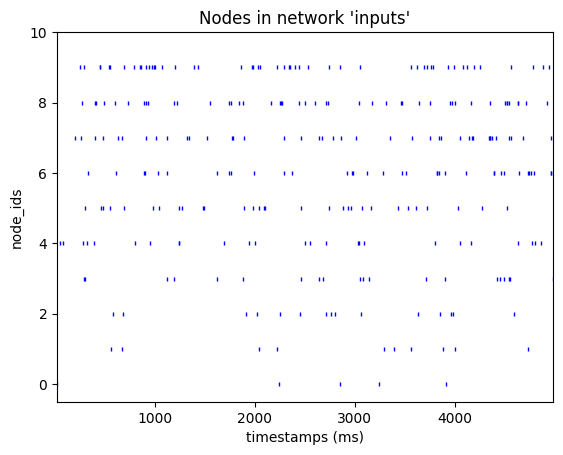

In [4]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(spikes_file='inputs/custom_spikes.csv', with_histogram=False)

We can now run the simulation with our custom csv input file

numprocs=1
2024-07-01 14:37:37,287 [INFO] Created log file
2024-07-01 14:37:37,346 [INFO] Building cells.
2024-07-01 14:37:38,036 [INFO] Building recurrent connections
2024-07-01 14:37:38,038 [INFO] Building virtual cell stimulations for LGN_spikes_sonata
2024-07-01 14:37:38,091 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-07-01 14:37:38,092 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-07-01 14:37:38,093 [INFO] Block save every 5000 steps
2024-07-01 14:37:38,536 [INFO]     step:5000 t_sim:500.00 ms
2024-07-01 14:37:38,984 [INFO]     step:10000 t_sim:1000.00 ms
2024-07-01 14:37:39,431 [INFO]     step:15000 t_sim:1500.00 ms
2024-07-01 14:37:39,885 [INFO]     step:20000 t_sim:2000.00 ms
2024-07-01 14:37:39,897 [INFO] Simulation completed in 1.806 seconds 


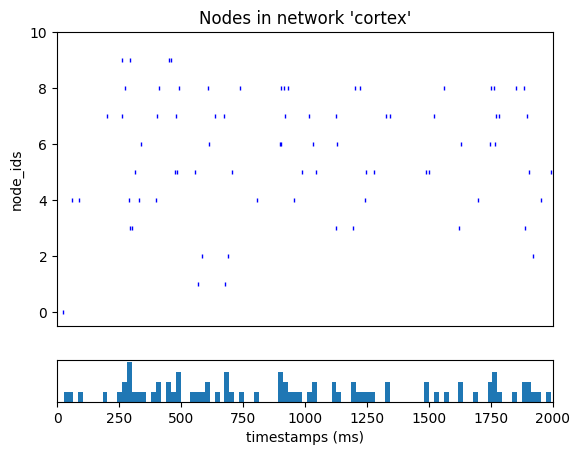

In [5]:
from bmtk.simulator import bionet
from bmtk.analyzer.spike_trains import plot_raster, to_dataframe

bionet.reset()
conf = bionet.Config.from_json('config.csv_spikes.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

_ = plot_raster(config_file='config.csv_spikes.json')

## Example: Dynamically generating custom spike-trains <a class="anchor" id="example-spikes-from-func">

Having to pregenerate spike-trains for you simulations inside a hdf5 or CSV file is computationally efficent and makes your results easier to reproduce and share. However, at times it may be beneificial for users to generate spike-trains dynamically during each simulation. If you are doing quick simulation and spot-checks it can be cumbersome having to regenerate a file beforehand. Or if a user is running thousand of simulations, or doing some kind of gradient search, the cost of having to create potentially thousand of spike files beforehand may not be reasonable.

BMTK also allows modlers the option to create their own special function which will generate new spike-trains at the start of each simulation. To do so, you only need to make changes to the configuration for a "spikes" input so that the **module** is set to value `function`, and instead of spikes_input you specify a **spikes_function** parameter that will be the name of your custom function

```json
"inputs": {
    "LGN_spikes_sonata": {
        "input_type": "spikes",
        "module": "function",
        "spikes_function": "my_spikes_generator",
        "node_set": "LGN"
    }
}
```

For BMTK to know where to find the `my_spikes_generator` you must then use the `@spikes_generator` at the top of a given function in your run_bmtk.py script (or any python file imported into run script). In the below example we use the following to return spike trains for every cell in the `LGN` node_set to fire at a constant rate (although different rates for differnt models)

In [6]:
from bmtk.simulator.bionet.io_tools import io
from bmtk.simulator.bionet import spikes_generator
import numpy as np

@spikes_generator
def my_spikes_generator(node, sim):
    io.log_info(f'Generating custom spike trains for {node.node_id} from node {node.population_name}')
    if node['pop_name'] == 'tON':
        return np.arange(100.0, sim.tstop, step=sim.dt*10)
    elif node['pop_name'] == 'tOFF':
        return np.arange(100.0, sim.tstop, step=sim.dt*20)
    else:
        return []


* All `spikes_generator` functions must have parameters `node` and `sim`
  * `node` allow you to access information about each node/cell like a dictionary.
  * `sim` is a class containing information about a current simulation, including information like start time (`sim.tstart`), stop_time (`sim.tstop`), step size (`sim.dt`) among other properties.
* The `spikes_generator` should return either a list or array of timestamps, in milliseconds, for each node.
* For good measure, we include logging statement. This is not required, but is good for debugging and making sure our custom function is being called.

When the simulation is ran the `my_spikes_generator` function will be called once for each node in the specified **node_set**. 

In [7]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.spikes_generator.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-07-01 14:37:40,226 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-07-01 14:37:40,303 [INFO] Building cells.
2024-07-01 14:37:48,802 [INFO] Building recurrent connections
2024-07-01 14:37:48,852 [INFO] Building virtual cell stimulations for LGN_spikes_sonata
2024-07-01 14:37:48,869 [INFO] Generating custom spike trains for 0 from LGN
2024-07-01 14:37:48,874 [INFO] Generating custom spike trains for 28 from LGN
2024-07-01 14:37:48,875 [INFO] Generating custom spike trains for 27 from LGN
2024-07-01 14:37:48,877 [INFO] Generating custom spike trains for 14 from LGN
2024-07-01 14:37:48,878 [INFO] Generating custom spike trains for 2 from LGN
2024-07-01 14:37:48,880 [INFO] Generating custom spike trains for 38 from LGN
2024-07-01 14:37:48,881 [INFO] Generating custom spike trains for 26 from LGN
2024-07-01 14:37:48,883 [INFO] Generating custom spike trains for 15 from LGN
2024-07-01 14:37:48,884 [INFO] Generating custom spike train

## Example: Incorporating real data from NWB files <a class="anchor" id="example-spikes-from-nwb">

While you can use tools like FilterNet or PoissonSpikeGenerator to create theoretical-to-realistic synaptic stimuli onto a network from a variety of different modes. But better yet, when actual experimental data is available, it is often possible to use just that. Especially as as more-and-more experimental electrophysiological data sets are being made publically available through resources like [DANDI](https://dandiarchive.org/) or [The Allen Brain Observatory](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels) we will want to not only use such data as a base-line for validating our models and comparing them to experiments, but also to use the data within specific simulations. For example, when modeling a network of one population and/or region, we will want use recordings of surrounding cells to help excite and inhibit our cells in a more realistic manner.

Traditionally a major issue with incorporating experimental electrophysiology data into simulations is trying to parse the wide variety of different ways the data was stored. Luckily, the [Neurodata Without Borders (NWB)](https://www.nwb.org/) have developed a format for storing experimental data which has seen a substantial amount of adoption in the field. BMTK can take these files and automatically insert them into simulations.

In this example we will take the previous model of the Mouse Primary Visual Cortex and add inputs that we know come from higher cortical regions (in this case just the VisL) along with the input from the LGN. For these added regions, we will use actual Neuropixels recordings of activity from these regions during presentation of drifting gratings

### Step 1: Download the data

First step is to find experimental NWB that includes spiking events. For our example we will use data from [Allen Institute Visual Coding dataset](https://observatory.brain-map.org/visualcoding/) downloaded using the AllenSDK. We will get a three experimental sessions that we know contains recordings the the VisL and hippocamus.

In [8]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

cache = EcephysProjectCache.from_warehouse(
    manifest='./ecephys_cache_dir/neuropixels.manifest.json'
)
cache.get_session_data(715093703)
cache.get_session_data(798911424)
cache.get_session_data(754829445)

/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.86G/2.86G [00:26<00:00, 106MB/s]
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
Downloading: 100%|███████████████████████████████████████████████████████████████

By defaul the NWB files will be downloaded into the *ecephys_cache_dir*. Since nwb files are essentially just structured HDF5 files you can use tools like [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or [h5py](https://www.h5py.org/) to read them once they have been downloaded. 

### Step 2: Connecting VISL and Hippocampal onto our V1 cells.

To simulation synaptic stimulation from the VisL cell recordings onto our V1 model, we will need to create a population of virtual cells representing the VisL neurons and their synapses to V1. Unforantely the electrophyiology data doesn't include information about network geometry and connectivity, so it is up to the modeler to decide how to connection the experimental data into our network.

As we did before we will separate node populations called 'VISl' and use the NetworkBuilder to create feedforward synaptic connections

```python
visl = NetworkBuilder('VISl')
visl.add_nodes(
    N=n_visl_units,
    model_type='virtual',
    ...
)
visl.add_edges(
    source=visal.nodes(),
    target=visp.nodes(ei='e'), 
    connection_rule=connection_rule_e2e,
    dynamics_params='AMPA_ExcToExc.json',
    model_template='Exp2Syn',
    ...
)

```

See the *./build_network.nwb_inputs.py* for the full script that builds the SONATA network found in *./network_nwb_inputs/*

### Step 3: Updating the configuration file to include NWB data.

Before we can run the simulation we must update the SONATA configuration file so that the simulation:
1. Knows which .nwb files to fetch spiking data from
2. Knows how to map cells (eg. NWB units) from our experimental data to cells (eg. SONATA nodes) in our 'VISl' and 'hippocampus' populations.
3. Know which interval interval in the experimental data to use in our simulation.

The most straight forward way of doing this is to add the following to our configuration file (*config.nwb_inputs.json*) in the "inputs" section:

```json
"inputs": {
    "hippo_spikes": {
        "input_type": "spikes",
        "module": "ecephys_probe",
        "node_set": "hippocampus",
        "input_file": "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "units": {
            "location": ["CA1", "CA3", "Po"]
        }
        "mapping": "sample",
        "interval": {
            "interval_name": "drifting_gratings",
            "temporal_frequency": 4.0,
            "orientation": 90
        }

    },
    "visl_spikes": {
        "input_type": "spikes",
        "module": "ecephys_probe",
        "node_set": "VISl",
        "input_file": "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "mapping": "sample",
        "units": {
            "location": "VISl",
        }
        "interval": {
            "interval_name": "drifting_gratings",
            "temporal_frequency": 4.0,
            "orientation": 90
        },
    }
}
```
* The **input_type** and **module** will always be set to values `spikes` and `ecephys_probe`, respectively, when importing extracellular electrophysiology NWB files into your simulation.
* The **node_set** is the subset of cells in our network to use as virtual cells that are generating spikes.
* The **input_file** in the name of the nwb file(s) to use for spikes. To use data from multiple sessions just use a list of files:
```json
    "input_file": [
        "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "./ecephys_cache_dir/session_798911424/session_798911424.nwb",
        "./ecephys_cache_dir/session_754829445/session_754829445.nwb"
    ]
```
* The **units** field tell us which units from the nwb file to take their spiking data from based on either specifc keywords and/or unit-id. In the Neuropixels NWB files each unit has an field called "location" to determine which region the data came from, which we can use here to tell that for our model's "hippocampus" cells use any data coming from either the CA1, CA3 or Po regions.
* **mapping** tells how to map NWB **units** -> SONATA **node_set**. Setting the value to `sample` will result in random mapping without replacement. You can also use options `sample_with_replacment`, useful if you have more nodes in your model than units in your data. Or if you have a specific mapping from NWB unit_ids to SONATA node_ids you can use optionn `units_map` (in which case **units** will point to a csv file).
* **interval** tells simulation which interval of time to fetch spikes from. Inside the NWB file there is a stimulus table that marks the stimuli at any given epoch of time. We use this table to only get spikes recorded which a "drifting grating" stimuli was present with a given orientation and frequency. If you know the specific time you can also use option
```json
    "interval": [start_time_ms, end_time_ms]
```

And finally we are ready to run our simulation

In [9]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.nwb_inputs.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-07-01 14:42:59,468 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-07-01 14:43:00,107 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2024-07-01 14:43:16,226 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2024-07-01 14:43:16,361 [INFO] Building virtual cell stimulations for LGN_spikes_sonata


INFO:NEURONIOUtils:Building virtual cell stimulations for LGN_spikes_sonata
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/local1/.local/miniconda-23.10.0/envs/bmtk-py3.10/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  retu

2024-07-01 14:43:23,118 [INFO] Building virtual cell stimulations for VISl_spikes_nwb


INFO:NEURONIOUtils:Building virtual cell stimulations for VISl_spikes_nwb


2024-07-01 14:43:26,165 [INFO] Building virtual cell stimulations for Hipp_spikes_nwb


INFO:NEURONIOUtils:Building virtual cell stimulations for Hipp_spikes_nwb


2024-07-01 14:43:28,453 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 2000.000 ms with the time step 0.100 ms


2024-07-01 14:43:28,455 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2024-07-01 14:43:28,457 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2024-07-01 14:44:34,293 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2024-07-01 14:45:43,762 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2024-07-01 14:46:52,837 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2024-07-01 14:48:03,836 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2024-07-01 14:48:03,866 [INFO] Simulation completed in 4.0 minutes, 35.41 seconds 


INFO:NEURONIOUtils:Simulation completed in 4.0 minutes, 35.41 seconds 


## Example: Forcing spotonaneous synaptic activity within a network <a class="anchor" id="example-spikes-from-spont">

So far in this tutorials we've focused on generating stimuli using synaptic stimuli coming from outside our main modeled network. In other tutorials we should different types in input to drive a simulation including current-clamps, voltage-clamps, and extracellar stimulation. While these can be generate both the kinds of stimuli we might see in the experiments and living brains, they tend to not be very grainular, especially when we want to study the secondary effects of activity within a network.

One option that BMTK gives use for having more grainular control of internal network activity is by forcing certain synapses to spontaneously fire at pre-determined times. Not only can this give us more control of network dynamics that would be much harder to achive using current clamps or feedforward spike trains. But it also let's us isolate external activity from recurrent activity.

In BMTK this is done by adding a new input type to the "inputs" section the SONATA config with **input_type** and **module** called `syn_activity`. And the minimum we must define the pre-synaptic cells that will spontaneously fire and a list of firing times:

```json
"syn_activity": {
  "input_type": "syn_activity",
  "module": "syn_activity",
  "precell_filter": {
      "population": "VISp",
      "ei": "e"
  },
  "timestamps": [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0]
}
```
* **precell_filter** determines the synapses to sponataneously activate based on the presynaptic/source cell. In this case we tell BMTK spontaneous activity to apply to synapses with a source-cell that has attributes `population==VISp` and `ei==e`. If you know exactly which cells you want to use you can filter by `node_id`:
```json
    "node_id": [0, 1, 2, 3],
```
* **timestamps** is a list of timestamps, in milliseconds, to activate the neuron following startup. If you have too many timestamps to add to the json directly, you can also pass in a string path to a txt file where each line is a timestamp.


In the above example, all the synapses with VISp, exc pre-synaptic connections will fire at the given timestamp. For further grainular control you can all set the **postcell_filter** too for filtering out synapses based on post-synaptic cell. For example if you want spontaneous firing in exc -> inh connections (the above example would also include exc -> exc synapses:

```json
"syn_activity": {
  "input_type": "syn_activity",
  "module": "syn_activity",
  "precell_filter": {
      "population": "VISp",
      "ei": "e"
  },
  "postcell_filter": {
      "population": "VISp",
      "ei": "i"
  },
  "timestamps": [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0]
}
```



In [11]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.spont_syns.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-07-01 14:48:03,914 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-07-01 14:48:03,987 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2024-07-01 14:48:33,155 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2024-07-01 14:48:36,855 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 2000.000 ms with the time step 0.100 ms


2024-07-01 14:48:36,857 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2024-07-01 14:48:36,858 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2024-07-01 14:49:48,780 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2024-07-01 14:51:01,284 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2024-07-01 14:52:15,289 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2024-07-01 14:53:29,406 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2024-07-01 14:53:29,421 [INFO] Simulation completed in 4.0 minutes, 52.57 seconds 


INFO:NEURONIOUtils:Simulation completed in 4.0 minutes, 52.57 seconds 
